In [1]:
# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

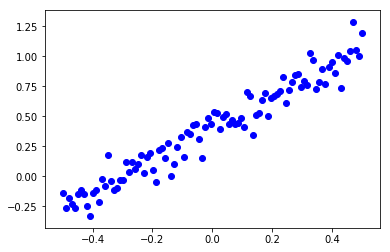

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[ 2.08207655]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 125.08207703]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[ 2.08207655]] [[ 125.08207703]]


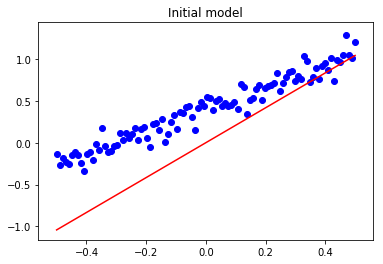

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.21825136244297028)
dloss/dW [[ 0.12951754]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.24299976229667664)
Itr 25 loss: variable(0.04066573455929756)
Itr 50 loss: variable(0.022569647058844566)
Itr 75 loss: variable(0.014893711544573307)


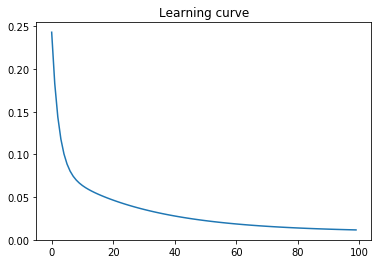

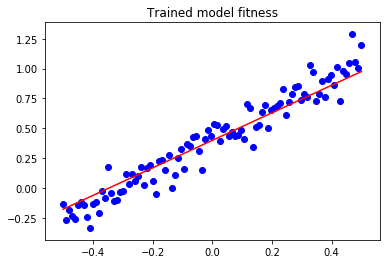

In [8]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    loss.backward()
    lr = 0.1
    model.W.data -= lr * model.W.grad
    model.b.data -= lr * model.b.grad
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


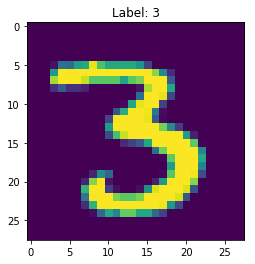

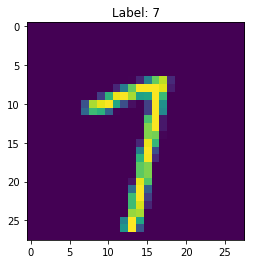

In [9]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [10]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0625; loss: 2.41807174683
accuracy: 0.845; loss: 0.64534741044
accuracy: 0.89; loss: 0.44008873105
accuracy: 0.885; loss: 0.406477024555
accuracy: 0.8975; loss: 0.361932949424
accuracy: 0.865; loss: 0.44186607182
accuracy: 0.93; loss: 0.298620316088
accuracy: 0.9225; loss: 0.318553515971
accuracy: 0.9175; loss: 0.340933135152
accuracy: 0.915; loss: 0.364767706692
accuracy: 0.925; loss: 0.299405208826
accuracy: 0.885; loss: 0.345542885363
accuracy: 0.895; loss: 0.314011129737
accuracy: 0.9075; loss: 0.322089455724
accuracy: 0.9175; loss: 0.271412815154
accuracy: 0.905; loss: 0.318414713442
accuracy: 0.94; loss: 0.293573652208
accuracy: 0.94; loss: 0.236604808569
accuracy: 0.905; loss: 0.299036397636
accuracy: 0.8975; loss: 0.303824467361
accuracy: 0.91; loss: 0.32599545747
accuracy: 0.8975; loss: 0.34077739656
accuracy: 0.91; loss: 0.414245692194
accuracy: 0.8975; loss: 0.341885394156
accuracy: 0.9275; loss: 0.294612416625
accuracy: 0.9225; loss: 0.303061201572


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [12]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return x
run(MLP(200, 10))

accuracy: 0.125; loss: 2.28807830811
accuracy: 0.8725; loss: 0.377149925232
accuracy: 0.945; loss: 0.200594601631
accuracy: 0.94; loss: 0.217425169349
accuracy: 0.965; loss: 0.155099045634
accuracy: 0.9575; loss: 0.137670180202
accuracy: 0.965; loss: 0.131735363007
accuracy: 0.955; loss: 0.164153493047
accuracy: 0.9525; loss: 0.189920149446
accuracy: 0.955; loss: 0.15164370954
accuracy: 0.9575; loss: 0.121687911749
accuracy: 0.955; loss: 0.123806851208
accuracy: 0.96; loss: 0.128338299394
accuracy: 0.9775; loss: 0.102566869855
accuracy: 0.97; loss: 0.0800235712528
accuracy: 0.965; loss: 0.0960385322571
accuracy: 0.9625; loss: 0.0942650020123
accuracy: 0.9575; loss: 0.136904770136
accuracy: 0.975; loss: 0.10200463593
accuracy: 0.9825; loss: 0.0551197814941
accuracy: 0.975; loss: 0.0683322685957
accuracy: 0.96; loss: 0.104039000869
accuracy: 0.985; loss: 0.0481979644299
accuracy: 0.9725; loss: 0.0941350388527
accuracy: 0.98; loss: 0.0528022569418
accuracy: 0.9775; loss: 0.0726878619194


Next you should try to implement logging test loss and see if the model is overfitting.

In [16]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for itr, batch in enumerate(test_iter):
                    xs = np.concatenate([datum[0][None, :] for datum in batch])
                    ys = np.array([datum[1] for datum in batch])
                    logits = model(xs)
                    loss = F.softmax_cross_entropy(logits, ys)
                    stats["test_loss"].append(float(loss.data))
                    stats["test_accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

test_accuracy: 0.2375; test_loss: 2.27237971306; accuracy: 0.125; loss: 2.30772161484
test_accuracy: 0.6675; test_loss: 1.18507318735; accuracy: 0.66; loss: 1.15700801373
test_accuracy: 0.67; test_loss: 1.09097609758; accuracy: 0.7075; loss: 0.993686830997
test_accuracy: 0.6925; test_loss: 1.06304833889; accuracy: 0.6775; loss: 1.00740951777
test_accuracy: 0.69; test_loss: 1.0466348958; accuracy: 0.7175; loss: 0.960682389736
test_accuracy: 0.76; test_loss: 0.898712111712; accuracy: 0.7975; loss: 0.856150866747
test_accuracy: 0.7725; test_loss: 0.864107968807; accuracy: 0.775; loss: 0.764436058998
test_accuracy: 0.79; test_loss: 0.8200342381; accuracy: 0.7775; loss: 0.817012144327
test_accuracy: 0.7775; test_loss: 0.856149164438; accuracy: 0.805; loss: 0.6962683779
test_accuracy: 0.8275; test_loss: 0.772883411646; accuracy: 0.8125; loss: 0.754257427454
test_accuracy: 0.8825; test_loss: 0.409314129353; accuracy: 0.88; loss: 0.374287686348


KeyboardInterrupt: 

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc